# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')

Load feature names.

In [3]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

#note to self, the loops are binarizing the data. An array of 126 zeros are initially set.
#for each feature present in the items list(22 observations) it gets flagged as a 1 and placed at the position 
#corresponding to its feature integer representation.

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.

X = np.array(X)
Y = np.array(Y)

# # Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)
print(train_labels.shape,test_labels.shape)


(7000, 126) (1124, 126)
(7000,) (1124,)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [5]:
def P1():
### STUDENT START ###
    components = train_data.shape[1]
#run PCA on all 126 features
    pca = PCA(n_components=components)
#fit train data with 126 components
    pca.fit_transform(train_data)
#compute percent of total variance explained by the first 50 components
    #maybe print this out...
    agg_var = sum(pca.explained_variance_ratio_[0:49])
    return print("The fraction of the total variance in the training data explained by the first 50 principal components is ",
            str(round(agg_var,2)))
### STUDENT END ###
P1()

The fraction of the total variance in the training data explained by the first 50 principal components is  0.98


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

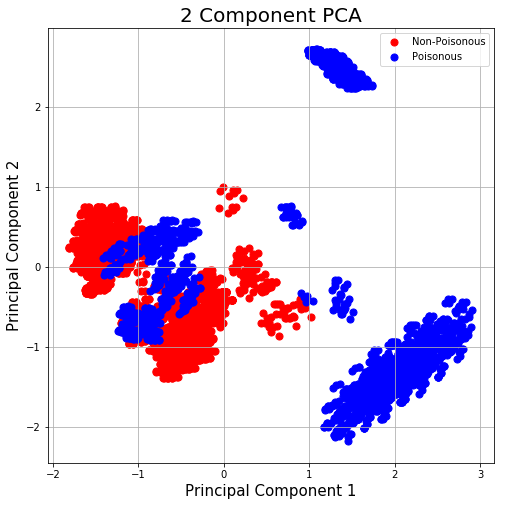

In [9]:
def P2():
### STUDENT START ###
    #generate instance of a 2-dimensional pca object
    pca = PCA(n_components=2)
    #fit the train data and apply the dimensionality reduction
    pca_fit = pca.fit_transform(train_data)
    #format component fits as columns in data fram
    pca_df = pd.DataFrame(data = pca_fit
                 , columns = ['principal component 1', 'principal component 2'])

    #add new column to data frame that contains the cases (0 = non-poisonous; 1 = poisonous)
    pca_df_agg = pd.concat([pca_df, pd.DataFrame(train_labels)], axis = 1)

    #plot a scatter plot of the component pairs and their corresponding case (color coded)
    #this is plotting 2 scatterplots - one over the other
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)

    targets = [0, 1]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        #apply boolean logic for all labels (colname = 0) that are equal to 0, then 1
        indices = pca_df_agg[0] == target
        #plot matching indices
        ax.scatter(pca_df_agg.loc[indices, 'principal component 1']
                   , pca_df_agg.loc[indices, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(['Non-Poisonous','Poisonous'])
    ax.grid()

### STUDENT END ### 

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

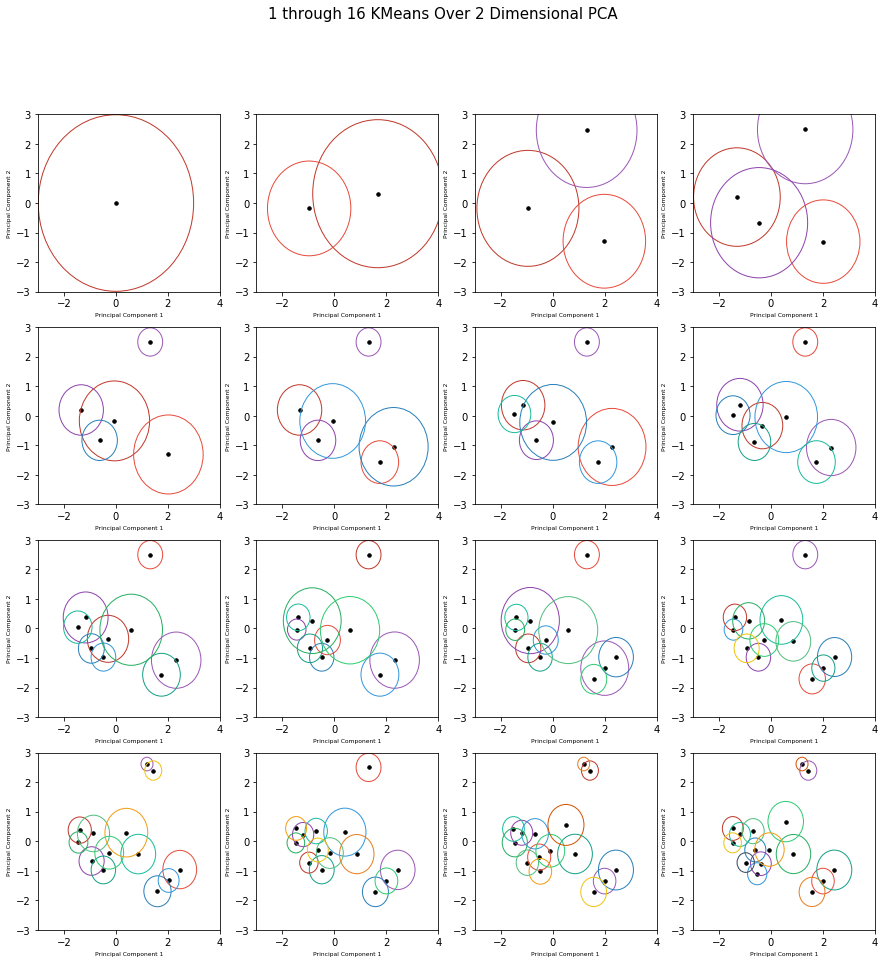

In [27]:
#def P3():
### STUDENT START ###
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(train_data)

fig, ax = plt.subplots(4, 4, figsize=(15,15))
fig.suptitle('1 through 16 KMeans Over 2 Dimensional PCA',fontsize=15)

row = -1
col = 0

#iterate through fitting 1-16 k means clusters
for k_cluster in np.arange(16):
    
    if k_cluster % 4 == 0:
        col = 0
        row += 1
        
    k_means = KMeans(n_clusters= k_cluster+1)
    k_means.fit(pca_fit)

    pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'])

    xx = []
    for l in k_means.labels_:
        centroids = k_means.cluster_centers_[l]
        xx.append(centroids)

    km_df = pd.DataFrame(xx, columns = ['center_x', 'center_y'])

    df = pd.concat([pca_df, km_df,pd.DataFrame(k_means.labels_,columns=['label'])], axis =1)                 
    
    #compute distance from circle center
    df['distance'] = np.sqrt(abs(df['pc1'] - df['center_x'])**2 +  abs(df['pc2'] - df['center_y'])**2)

    circle_df = pd.DataFrame(df.groupby(['label', 'center_x','center_y'],as_index=False)['distance'].max())

    color_scheme =['#C0392B','#E74C3C','#9B59B6','#8E44AD','#2980B9','#3498DB','#1ABC9C','#16A085',
                  '#27AE60','#2ECC71','#52BE80','#F1C40F','#F39C12','#E67E22','#D35400','#34495E']

    nrows = circle_df.shape[0]

    for cluster in np.arange(nrows):
        x = circle_df.iloc[cluster,1]
        y = circle_df.iloc[cluster,2]
        r = circle_df.iloc[cluster,3]
        circle = plt.Circle((x,y),r,color = color_scheme[cluster],fill = False)
        ax[row,col].set_xlim([-3,4])
        ax[row,col].set_ylim([-3,3])
        ax[row,col].set_xlabel('Principal Component 1', fontsize = 6)
        ax[row,col].set_ylabel('Principal Component 2', fontsize = 6)
        ax[row,col].add_artist(circle)
        ax[row,col].scatter(x,y,color = 'k',s = 12)
    
    col += 1

    ## STUDENT END ###

#P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

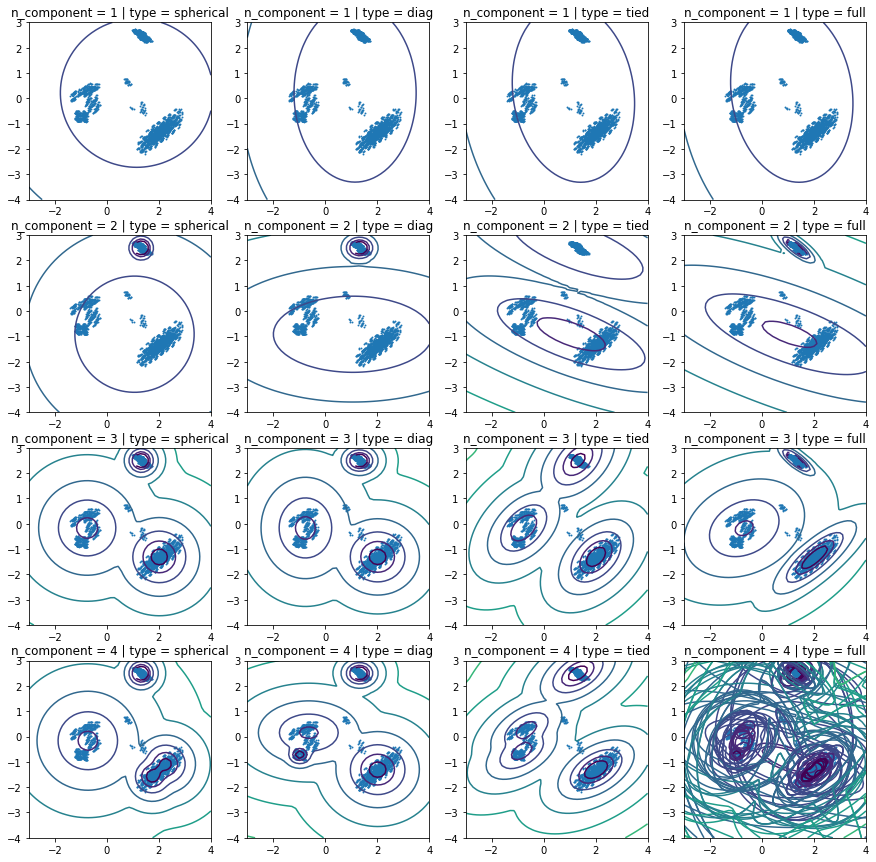

In [53]:
#def P4():
### STUDENT START ###

# set plot area (16 plots total)
fig, ax = plt.subplots(4,4,figsize=(15,15))

#set the gridspace - using the coordinates revealed in problem 3
x = np.linspace(-3., 4.)
y = np.linspace(-4., 3.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

#generate instance of a 2-dimensional pca object
pca = PCA(n_components=2)
#fit the train data and apply the dimensionality reduction
pca_fit = pca.fit_transform(train_data)
#isolate poisonous values
pca_pos = pca_fit[np.where(train_labels==1)]
# fit a Gaussian Mixture Model for the positive examples in 2d projected data
covariance_types = ['spherical', 'diag', 'tied', 'full']

###----Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full')---###
for component in np.arange(4):
    for cov_type in np.arange(len(covariance_types)):
        #fit the GMM model
        clf = mixture.GaussianMixture(n_components=component+1, covariance_type=covariance_types[cov_type])
        clf.fit(pca_pos)
        #compute the weighted log probabilities for each sample and reshape into coordinate space
        Z = -clf.score_samples(XX)
        Z = Z.reshape(X.shape)
        #generate estimated density contours
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

        #plot combination of component and covariance type
        ax[component,cov_type].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
        ax[component,cov_type].scatter(pca_pos[:, 0], pca_pos[:, 1], .8)
        plt_title = 'n_component = '+ str(component+1) + ' | type = ' + str(covariance_types[cov_type])
        ax[component,cov_type].set_title(plt_title,loc='center')
        
### STUDENT END ###
#P4()  
        
    

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [15]:
def P5():
### STUDENT START ###
    #generate instance of a 2-dimensional pca object
    pca = PCA(n_components=2)

    #fit the train data and apply the dimensionality reduction to both train and test
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)

    #isolate poisonous and non-poisonous observations
    pca_pos = pca_train[np.where(train_labels==1)]
    pca_neg = pca_train[np.where(train_labels==0)]

#---Fit two 4-component full covariance GMMs, one for the positive and one for the negative in 2d projected data---#
    GMM_pos = mixture.GaussianMixture(n_components=4, covariance_type='full')
    GMM_neg = mixture.GaussianMixture(n_components=4, covariance_type='full')
    GMM_pos_fit = GMM_pos.fit(pca_pos)
    GMM_neg_fit = GMM_neg.fit(pca_neg)

#---Predict the test examples by choosing the label for which the model gives a larger probability---#

    #transform the test data and apply pca dimensionality reduction
    pca_test_fit = pca.transform(test_data)
    pos_score = GMM_pos_fit.score_samples(pca_test_fit)
    neg_score = GMM_neg_fit.score_samples(pca_test_fit)

    #compute the accuracy:
#---Predict the test examples by choosing the label for which the model gives a larger probability--#
    accuracy = round(sum(pos_score>neg_score)/sum(test_labels),2)
    print("The accuracy using two 4-component full covariance GMMs is", str(accuracy))
### STUDENT END ###

P5()

The accuracy using two 4-component full covariance GMMs is 0.96


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [6]:
#def P6():
### STUDENT START ###
pca_comp = np.arange(1,51)
gmm_comp = np.arange(1, 201)
gmm_cov = ['spherical', 'diag', 'tied', 'full']

## Schema of all_combs = [gmm_cov, pca_comp, gmm_comp]
all_combs = [[i, j, k] for i in gmm_cov for j in pca_comp for k in gmm_comp]
## Schema of all_combs = [gmm_cov, pca_comp, gmm_comp, params]
all_combs_params = []

for i in all_combs:
    if i[0] == 'spherical':
        if (i[1]+1)*i[2]*2 <= 50:
            all_combs_params.append(i + [(i[1]+1)*i[2]*2])
    elif i[0] == 'diag':
        if (i[1]+i[1])*i[2]*2  <= 50:
            all_combs_params.append(i + [(i[1]+i[1])*i[2]*2 ])
    elif i[0] == 'tied':
        if (i[1]+i[1]*(i[1]-1)/2)*i[2]*2 <= 50:
            all_combs_params.append(i + [(i[1]+i[1]*(i[1]-1)/2)*i[2]*2])
    else:
        if i[1]*(i[1]+i[1]*(i[1]-1)/2)*i[2]*2 <= 50:
            all_combs_params.append(i + [i[1]*(i[1]+i[1]*(i[1]-1)/2)*i[2]*2])

### Run models
results = []
for i in all_combs_params:
    clf_pca = PCA(n_components=i[1])
    pca_train = clf_pca.fit_transform(train_data)
    pca_test = clf_pca.transform(test_data)
    
    clf_gmm = GaussianMixture(n_components = i[2], covariance_type = i[0])
    clf_gmm_fit = clf_gmm.fit(pca_train)
    pred_labels = clf_gmm_fit.predict(pca_test)
    results.append(i + [np.sum(test_labels==pred_labels)/len(test_labels)])
    
final_results = sorted(results, key = lambda x : x[4], reverse=True)
final_results
### STUDENT END ###
#P6()

[['spherical', 5, 2, 24, 0.89323843416370108],
 ['spherical', 8, 2, 36, 0.89234875444839856],
 ['spherical', 9, 2, 40, 0.89145907473309605],
 ['diag', 2, 2, 16, 0.88790035587188609],
 ['tied', 4, 2, 40.0, 0.88701067615658358],
 ['diag', 6, 2, 48, 0.88523131672597866],
 ['diag', 1, 2, 8, 0.88434163701067614],
 ['full', 1, 2, 4.0, 0.88434163701067614],
 ['tied', 1, 2, 4.0, 0.88345195729537362],
 ['tied', 3, 2, 24.0, 0.68149466192170816],
 ['spherical', 3, 2, 16, 0.67615658362989328],
 ['spherical', 6, 2, 28, 0.67615658362989328],
 ['full', 2, 2, 24.0, 0.67615658362989328],
 ['tied', 1, 3, 6.0, 0.67259786476868333],
 ['spherical', 2, 2, 12, 0.6708185053380783],
 ['diag', 1, 3, 12, 0.66903914590747326],
 ['tied', 3, 4, 48.0, 0.58540925266903909],
 ['spherical', 2, 3, 18, 0.57117437722419928],
 ['diag', 2, 3, 24, 0.57117437722419928],
 ['diag', 3, 2, 24, 0.57117437722419928],
 ['tied', 3, 3, 36.0, 0.57117437722419928],
 ['full', 2, 3, 36.0, 0.57117437722419928],
 ['tied', 2, 4, 24.0, 0.5373